#0-Importing the libraries

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import random
import numpy as np
#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing



#Sampling Libraries
from imblearn.over_sampling import SMOTE 

#Imputation Libraries
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Data
from sklearn.datasets import load_boston

#Costant Value
from sklearn.feature_selection import VarianceThreshold

#Encoding Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns

#1 Data Preparation

##1.1 Loading Data


In [4]:
camera=94716

In [7]:
#Images are converted to numpy arrays and saved on the disk
fault1=np.load(f"fault1_L1K1_{camera}.npy")
fault2=np.load(f"fault2_L1K1K5_{camera}.npy")
fault3=np.load(f"fault3_L2K3_{camera}.npy")
fault4=np.load(f"fault4_L2K6_7_{camera}.npy")
X_defect_test_init=np.concatenate((fault1,fault2,fault3),axis = 0)
healthy_data=np.load(f"healthy_{camera}.npy")

##1.2 Normalization

In [8]:
max=healthy_data.max()
min=healthy_data.min()
healthy_data=(healthy_data-min)/(max-min)
max=X_defect_test_init.max()
min=X_defect_test_init.min()
X_defect_test_init=(X_defect_test_init-min)/(max-min)
max=fault4.max()
min=fault4.min()
fualt4=(fault4-min)/(max-min)

## 1.3 Extracting 6 samples for visualizations

In [9]:
healthy_start=healthy_data[0]
np.save(f'healthy_start_{camera}', healthy_start)
healthy_data=np.delete(healthy_data,0,axis=0)
healthy_mid=healthy_data[int(healthy_data.shape[0]/2)]
healthy_data=np.delete(healthy_data,int(healthy_data.shape[0]/2),axis=0)
np.save(f'healthy_mid_{camera}', healthy_mid)
healthy_end=healthy_data[-1]
healthy_data=np.delete(healthy_data,-1,axis=0)
np.save(f'healthy_end_{camera}', healthy_end)


faulty_start=fualt4[0]
np.save(f'faulty_start_{camera}', faulty_start)
fault4=np.delete(fault4,0,axis=0)
faulty_mid=fualt4[int(fualt4.shape[0]/2)]
np.save(f'faulty_mid_{camera}', faulty_mid)
fault4=np.delete(fault4,int(fault4.shape[0]/2),axis=0)
faulty_end=fualt4[-1]
fault4=np.delete(fault4,-1,axis=0)
np.save(f'faulty_end_{camera}', faulty_end)
X_defect_class=fault4

## 1.4 Splitting the Data

In [10]:
#Shuffling the datasets
np.random.shuffle(X_defect_test_init)
np.random.shuffle(healthy_data)
np.random.shuffle(X_defect_class)

In [11]:
index=X_defect_class.shape[0]
X_healthy_class=healthy_data[:index]
X_train_all=healthy_data[index:]
X_train_init=X_train_all[:round(X_train_all.shape[0]*.8)]
X_val_init=X_train_all[round(X_train_all.shape[0]*.8):]

In [12]:
X_train= X_train_init[:,:,:,np.newaxis]
X_val= X_val_init[:,:,:,np.newaxis]
X_defect_test= X_defect_test_init[:,:,:,np.newaxis]

print(f"""shape of numpy array data:
X_train-->{X_train.shape}
X_val-->{X_val.shape}
X_defect_test-->{X_defect_test.shape}
X_healthy_class-->{X_healthy_class.shape}
X_defect_class-->{X_defect_class.shape}""")


shape of numpy array data:
X_train-->(1482, 32, 32, 1)
X_val-->(370, 32, 32, 1)
X_defect_test-->(695, 32, 32, 1)
X_healthy_class-->(258, 32, 32)
X_defect_class-->(258, 32, 32)


In [13]:
#Converting datasets to tensors
X_train=tf.convert_to_tensor(X_train)
X_val=tf.convert_to_tensor(X_val)
X_defect_test= tf.convert_to_tensor(X_defect_test)
print(f"""shape of numpy array data:
X_train-->{X_train.shape}
X_val-->{X_val.shape}
X_defect_test-->{X_defect_test.shape}
X_healthy_class-->{X_healthy_class.shape}
X_defect_class-->{X_defect_class.shape}""")

shape of numpy array data:
X_train-->(1482, 32, 32, 1)
X_val-->(370, 32, 32, 1)
X_defect_test-->(695, 32, 32, 1)
X_healthy_class-->(258, 32, 32)
X_defect_class-->(258, 32, 32)


#2 Model Training

## 2.1 Create and compile Models

In [14]:
SIZE=32

2.1.1 CAE with MSE

In [15]:
#Encoder
encoder_mse = keras.models.Sequential()
encoder_mse.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
encoder_mse.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_mse.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder_mse.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_mse.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
encoder_mse.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

#Decoder

decoder_mse = keras.models.Sequential()

decoder_mse .add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
decoder_mse .add(keras.layers.UpSampling2D((2, 2)))
decoder_mse .add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
decoder_mse .add(keras.layers.UpSampling2D((2, 2)))
decoder_mse .add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
decoder_mse .add(keras.layers.UpSampling2D((2, 2)))
decoder_mse .add(keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

cae_mse=keras.models.Sequential([encoder_mse,decoder_mse])
cae_mse.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

2.1.2 CAE with SSIM LOS

In [16]:
#Defining Loss function for SSIM
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))
  

In [17]:
#Encoder
encoder_ssim = keras.models.Sequential()
encoder_ssim.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
encoder_ssim.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_ssim.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder_ssim.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_ssim.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
encoder_ssim.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

#Decoder

decoder_ssim = keras.models.Sequential()

decoder_ssim.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
decoder_ssim.add(keras.layers.UpSampling2D((2, 2)))
decoder_ssim.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
decoder_ssim.add(keras.layers.UpSampling2D((2, 2)))
decoder_ssim.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
decoder_ssim.add(keras.layers.UpSampling2D((2, 2)))
decoder_ssim.add(keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

cae_ssim=keras.models.Sequential([encoder_mse,decoder_mse])

In [18]:
cae_ssim.compile(optimizer='adam', loss=SSIMLoss)

##2.2 Training and Saving Models

In [20]:
def train_ae(model,normal_data_train,normal_data_validation,epochs):
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  history=model.fit(normal_data_train,normal_data_train,epochs=epochs,validation_data=[normal_data_validation,normal_data_validation],callbacks=[tensorboard_callback])

In [21]:
train_ae(cae_mse,X_train,X_val,epochs=200)
cae_mse.save('cae_mse_200_epochs_v_2_0.h5')
encoder_mse.save('encoder_mse_200_epochs_v_2_0.h5')
encoder_mse.save_weights('encoder_mse_weights_200_epochs_v_2_0.h5')

Epoch 1/200
47/47 [==============================] - 10s 191ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 2/200
47/47 [==============================] - 13s 277ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/200
47/47 [==============================] - 9s 192ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/200
47/47 [==============================] - 9s 192ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 8.0410e-04 - val_mse: 8.0410e-04
Epoch 5/200
47/47 [==============================] - 9s 186ms/step - loss: 8.5983e-04 - mse: 8.5983e-04 - val_loss: 7.4126e-04 - val_mse: 7.4126e-04
Epoch 6/200
47/47 [==============================] - 9s 191ms/step - loss: 6.8960e-04 - mse: 6.8960e-04 - val_loss: 5.6599e-04 - val_mse: 5.6599e-04
Epoch 7/200
47/47 [==============================] - 9s 186ms/step - loss: 5.5321e-04 - mse: 5.5321e-04 - val_loss: 5.2162e-04 - val_mse: 5.2162e-04
Epoch 8/200

In [48]:
train_ae(cae_ssim,X_train,X_val,epochs=200)
cae_ssim.save('cae_ssim_200_epochs_v_2_0.h5')

Epoch 1/200
47/47 [==============================] - 20s 390ms/step - loss: 0.0309 - val_loss: 0.0268
Epoch 2/200
47/47 [==============================] - 16s 337ms/step - loss: 0.0269 - val_loss: 0.0263
Epoch 3/200
47/47 [==============================] - 18s 382ms/step - loss: 0.0265 - val_loss: 0.0262
Epoch 4/200
47/47 [==============================] - 16s 338ms/step - loss: 0.0265 - val_loss: 0.0261
Epoch 5/200
47/47 [==============================] - 16s 337ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 6/200
47/47 [==============================] - 16s 338ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 7/200
47/47 [==============================] - 16s 335ms/step - loss: 0.0261 - val_loss: 0.0256
Epoch 8/200
47/47 [==============================] - 16s 336ms/step - loss: 0.0260 - val_loss: 0.0254
Epoch 9/200
47/47 [==============================] - 16s 336ms/step - loss: 0.0258 - val_loss: 0.0254
Epoch 10/200
47/47 [==============================] - 16s 334ms/step - loss: 0.025

#2 Finding Anomalies test phase

loading Saved Models

In [22]:
%cd /content/drive/My Drive/SRH Heidelberg/Publication ABB/models/94716

/content/drive/My Drive/SRH Heidelberg/Publication ABB/models/94716


In [23]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [24]:
cae_mse=tf.keras.models.load_model('cae_mse_200_epochs_v_2_0.h5')
cae_ssim=tf.keras.models.load_model('cae_ssim_200_epochs_v_2_0.h5',custom_objects={'SSIMLoss': SSIMLoss})
encoder_mse=tf.keras.models.load_model('encoder_mse_200_epochs_v_2_0.h5')

##2.2 Visualizing Input and output of models for one instance

2.2.1 Visualizing A(x) using MSE

1/1 [==============================] - 0s 32ms/step


Text(0.5, 0, 'MSE A(x)=10.6614')

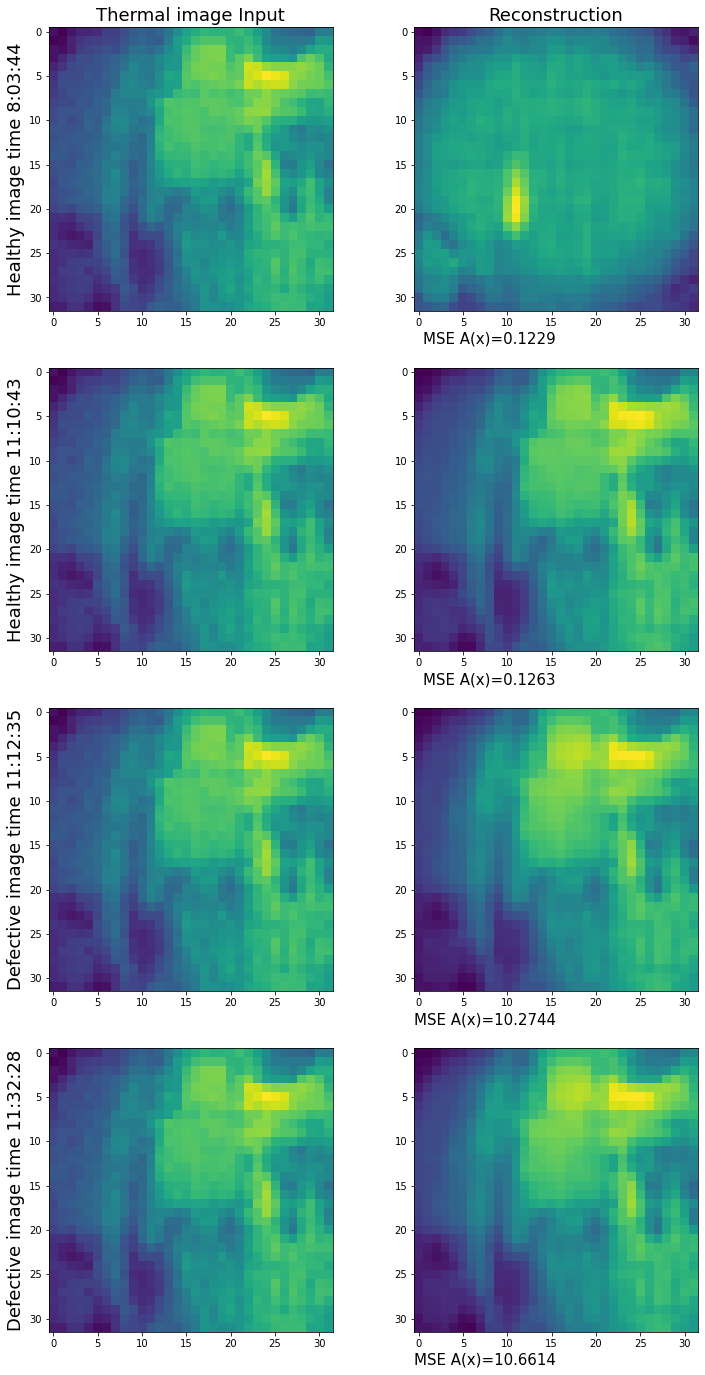

In [25]:
import matplotlib.pyplot as plt

rows, cols = 4, 2
fig, ax = plt.subplots(rows, cols,figsize=(12,24))
predicted = cae_mse.predict(healthy_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
error=((healthy_start-predicted)**2).sum()
ax[0,0].imshow(healthy_end)
ax[0,0].set_title(f"Thermal image Input",fontsize=18, fontweight=20)
ax[0,0].set_ylabel("Healthy image time 8:03:44",fontsize=18, fontweight=20)
ax[0,1].imshow(predicted)
ax[0,1].set_title(f"Reconstruction",fontsize=18, fontweight=20)
ax[0,1].set_xlabel(f"MSE A(x)={round(error,4)}",fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_mse.predict(healthy_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
error=((healthy_end-predicted)**2).sum()
ax[1,0].imshow(healthy_end)
ax[1,0].set_ylabel("Healthy image time 11:10:43",fontsize=18, fontweight=20)
ax[1,1].imshow(predicted)
ax[1,1].set_xlabel(f'MSE A(x)={round(error,4)}',fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_mse.predict(faulty_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
error=((faulty_start-predicted)**2).sum()
ax[2,0].imshow(healthy_end)
ax[2,0].set_ylabel("Defective image time 11:12:35",fontsize=18, fontweight=20)
ax[2,1].imshow(predicted)
ax[2,1].set_xlabel(f'MSE A(x)={round(error,4)}',fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_mse.predict(faulty_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
error=((faulty_end-predicted)**2).sum()
ax[3,0].imshow(healthy_end)
ax[3,0].set_ylabel("Defective image time 11:32:28",fontsize=18, fontweight=20)
ax[3,1].imshow(predicted)
ax[3,1].set_xlabel(f'MSE A(x)={round(error,4)}',fontsize=15,fontweight=20,horizontalalignment='right')


2.2.2 Visualizing A(x) using SSIM

1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.8/dist-packages/skimage/metrics/_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


1/1 [==============================] - 0s 21ms/step


Text(0.5, 0, 'SSIM A(x)=0.7307')

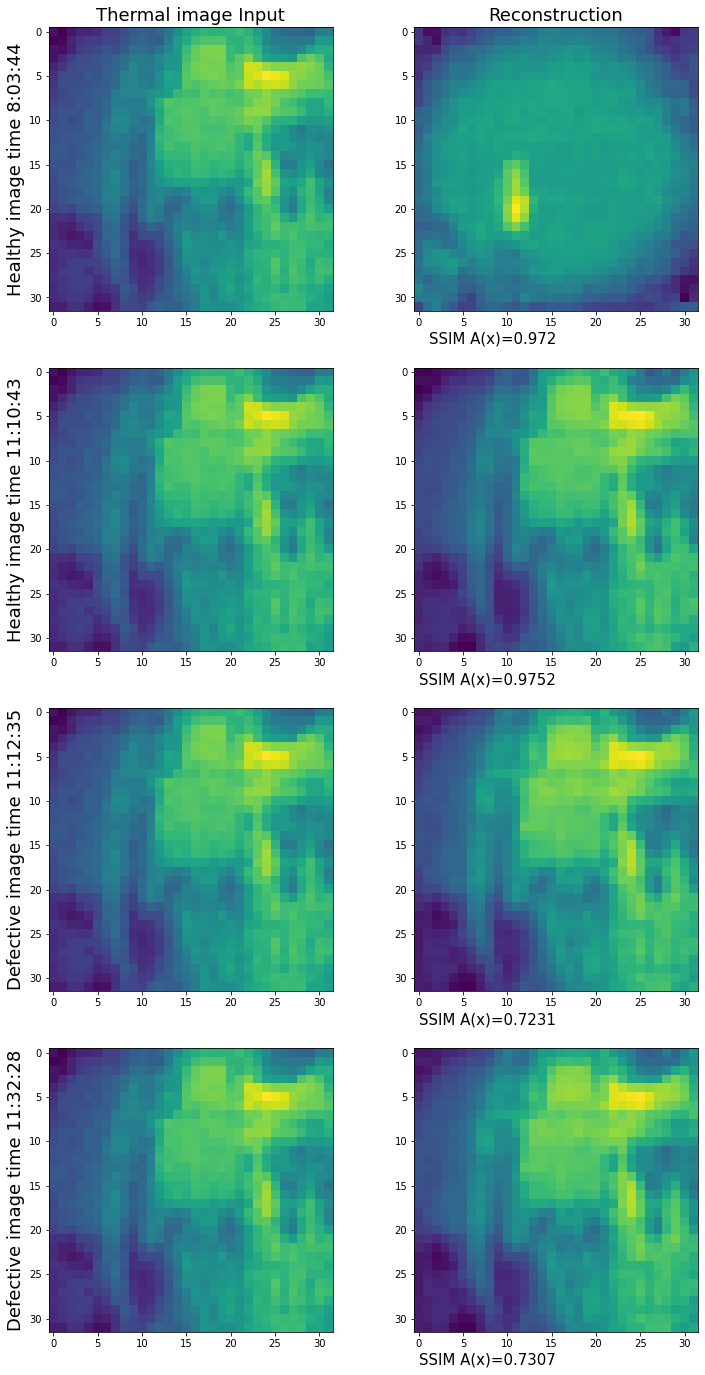

In [26]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

rows, cols = 4, 2
fig, ax = plt.subplots(rows, cols,figsize=(12,24))
predicted = cae_ssim.predict(healthy_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ssim_val,residual=ssim(healthy_start,predicted,gradient=True,win_size=3,multichannel=True)
ax[0,0].imshow(healthy_end)
ax[0,0].set_title(f"Thermal image Input",fontsize=18, fontweight=20)
ax[0,0].set_ylabel("Healthy image time 8:03:44",fontsize=18, fontweight=20)
ax[0,1].imshow(predicted)
ax[0,1].set_title(f"Reconstruction",fontsize=18, fontweight=20)
ax[0,1].set_xlabel(f"SSIM A(x)={round(ssim_val,4)}",fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_ssim.predict(healthy_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ssim_val,residual=ssim(healthy_end,predicted,gradient=True,win_size=3,multichannel=True)
ax[1,0].imshow(healthy_end)
ax[1,0].set_ylabel("Healthy image time 11:10:43",fontsize=18, fontweight=20)
ax[1,1].imshow(predicted)
ax[1,1].set_xlabel(f'SSIM A(x)={round(ssim_val,4)}',fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_ssim.predict(faulty_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ssim_val,residual=ssim(faulty_start,predicted,gradient=True,win_size=3,multichannel=True)
ax[2,0].imshow(healthy_end)
ax[2,0].set_ylabel("Defective image time 11:12:35",fontsize=18, fontweight=20)
ax[2,1].imshow(predicted)
ax[2,1].set_xlabel(f'SSIM A(x)={round(ssim_val,4)}',fontsize=15, fontweight=20,horizontalalignment='right')

predicted = cae_ssim.predict(faulty_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ssim_val,residual=ssim(faulty_end,predicted,gradient=True,win_size=3,multichannel=True)
ax[3,0].imshow(healthy_end)
ax[3,0].set_ylabel("Defective image time 11:32:28",fontsize=18, fontweight=20)
ax[3,1].imshow(predicted)
ax[3,1].set_xlabel(f'SSIM A(x)={round(ssim_val,4)}',fontsize=15,fontweight=20,horizontalalignment='right')


##2.3 Calculating  MSE Anomaly Scores

In [27]:
def calc_recon_error(batch_data):
  recon_error_list=[]
  for i in range(0, batch_data.shape[0]):
    data  = batch_data[i]
    reconstruction = cae_mse.predict(data.reshape(1,32,32,1))
    reconstruction=np.reshape( reconstruction,(32,32))
    data=np.reshape(data,(32,32))
    reconstruction_error=((data-reconstruction)**2).sum()
    recon_error_list.append(reconstruction_error)
  return recon_error_list

In [28]:
#anomaly scores for threshold determination
train_recon_errors=calc_recon_error(X_train.numpy())
anomaly_recon_errors= calc_recon_error(X_defect_test.numpy())
#anomaly scores for classification
normal_recon_class= calc_recon_error(X_healthy_class)
anomaly_recon_class= calc_recon_error(X_defect_class)

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


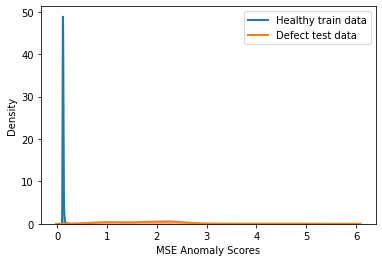

In [29]:
#Visualizing MSE anomaly score distribution
ax=sns.distplot(train_recon_errors, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"black"},
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},label="Healthy train data")

ax=sns.distplot(anomaly_recon_errors, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"red"}, 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 2},label="Defect test data")


ax.set(xlabel='MSE Anomaly Scores', ylabel='Density')
l1 = ax.lines[0]
l2 = ax.lines[1]

x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="black", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
ax.legend(loc='upper right')
plt.savefig(f'dist{camera}.png')
plt.show(block=False)

In [30]:
#Function to creat pandas dataset. Dataset is used for labeling the reconstruction errors
def create_dataset(normal_reconstructions,anomally_reconstructions):
  dataset=np.row_stack((np.column_stack((normal_reconstructions,np.ones((normal_reconstructions.shape[0],),dtype=np.int64))),np.column_stack((anomally_reconstructions,np.zeros((anomally_reconstructions.shape[0],),dtype=np.int64)))))
  df=pd.DataFrame(dataset,columns=['reconstructions','label'])
  df = df.sample(frac=1).reset_index(drop=True)
  return df


In [31]:
df_scatter_plot_mse=create_dataset(np.array(train_recon_errors),np.array(anomaly_recon_errors))
df_mse=create_dataset(np.array(normal_recon_class),np.array(anomaly_recon_class))

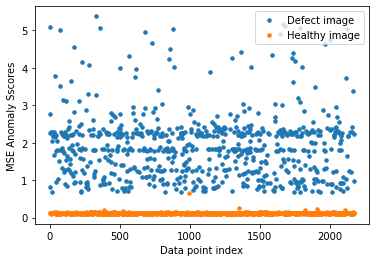

In [32]:
#Visualizing the MSE anomaly scores with scatter plot
groups = df_scatter_plot_mse.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstructions, marker='o', ms=3.5, linestyle='',
            label= "Healthy image" if name == 1 else "Defect image")
ax.legend(loc='upper right')
plt.ylabel("MSE Anomaly Sscores")
plt.xlabel("Data point index")
plt.savefig(f'scatter{camera}.png')
plt.show();

##2.4 Calculating  SSIM Anomaly Scores





In [33]:
def calc_ssim(batch_data):
  ssim_list=[]
  for i in range(0, batch_data.shape[0]):
    data  = batch_data[i]
    reconstruction = cae_ssim.predict(data.reshape(1,32,32,1))
    reconstruction=np.reshape( reconstruction,(32,32))
    data=np.reshape(data,(32,32))
    ssim_index=ssim(data,reconstruction)
    ssim_list.append(ssim_index)
  return ssim_list

In [34]:
#anomaly scores for threshold determination
train_ssim=calc_ssim(X_train.numpy())
anomaly_ssim= calc_ssim(X_defect_test.numpy())

#anomaly scores for classification
normal_ssim_class= calc_ssim(X_healthy_class)
anomaly_ssim_class= calc_ssim(X_defect_class)

1/1 [==============================] - 0s 19ms/step


<ipython-input-33-b50657090f7b>:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_index=ssim(data,reconstruction)


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


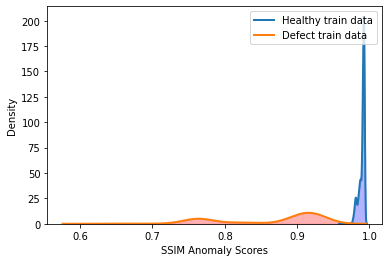

In [35]:
#Visualizing SSIM anomaly score distribution
ax=sns.distplot(train_ssim, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"blue"},
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},label="Healthy train data")
ax=sns.distplot(anomaly_ssim, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"red"}, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},label="Defect train data")


ax.set(xlabel='SSIM Anomaly Scores', ylabel='Density')
l1 = ax.lines[0]
l2 = ax.lines[1]

x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="blue", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
ax.legend(loc='upper right')
plt.savefig(f'dist{camera}.png')
plt.show(block=False)

In [36]:
df_scatter_plot_ssim=create_dataset(np.array(train_ssim),np.array(anomaly_ssim))
df_ssim=create_dataset(np.array(normal_ssim_class),np.array(anomaly_ssim_class))

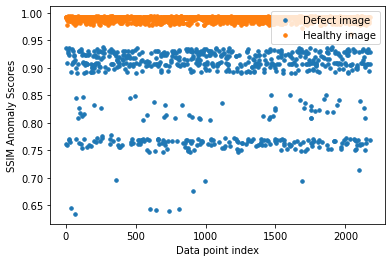

In [37]:
#Visualizing the SSIM anomaly scores with scatter plot
groups = df_scatter_plot_ssim.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstructions, marker='o', ms=3.5, linestyle='',
            label= "Healthy image" if name == 1 else "Defect image")
ax.legend(loc='upper right')
plt.ylabel("SSIM Anomaly Sscores")
plt.xlabel("Data point index")
plt.savefig(f'scatter{camera}.png')
plt.show();

##2.5 Calculating  KDE Anomaly Scores

In [38]:
from sklearn.neighbors import KernelDensity

In [39]:
encoded_images = encoder_mse.predict(X_train)

47/47 [==============================] - 1s 17ms/step


In [40]:
encoded_images.shape

(1482, 4, 4, 16)

In [41]:
encoder_mse.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

In [42]:
#Get encoded output of input images = Latent space
encoded_images = encoder_mse.predict_generator(X_train)
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoded_images_vector = [np.reshape(img, (256)) for img in encoded_images]
#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

<ipython-input-42-8ac413b03b74>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_mse.predict_generator(X_train)


In [43]:
def calc_density_error(batch_images):
  density_list=[]
  for i in range(0, batch_images.shape[0]):
    img  = batch_images[i].reshape(1,32,32,1)
    encoded_img = encoder_mse.predict(img) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (256)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    density_list.append(density)

  average_density = np.mean(np.array(density_list))  
  stdev_density = np.std(np.array(density_list)) 
        
  return density_list

In [44]:
#anomaly scores for threshold determination
train_kde=calc_density_error(X_train.numpy())
anomaly_kde=calc_density_error(X_defect_test.numpy())

#anomaly scores for classification
normal_kde_class=calc_density_error(X_healthy_class)
anomaly_kde_class=calc_density_error(X_defect_class)

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


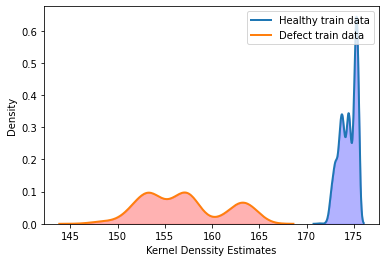

In [45]:
#Visualizing kde anomaly score distribution
ax=sns.distplot(train_kde, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"blue"},
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},label="Healthy train data")
ax=sns.distplot(anomaly_kde, hist=False, kde=True, 
             bins=int(200),fit_kws={"color":"red"}, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},label="Defect train data")
ax.set(xlabel='Kernel Denssity Estimates', ylabel='Density')
l1 = ax.lines[0]
l2 = ax.lines[1]

x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="blue", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
ax.legend(loc='upper right')
plt.savefig(f'kde_dist{camera}.png')
plt.show(block=False)

In [46]:
def create_dataset(normal_reconstructions,anomally_reconstructions):
  dataset=np.row_stack((np.column_stack((normal_reconstructions,np.ones((normal_reconstructions.shape[0],),dtype=np.int64))),np.column_stack((anomally_reconstructions,np.zeros((anomally_reconstructions.shape[0],),dtype=np.int64)))))
  df=pd.DataFrame(dataset,columns=['kde','label'])
  df = df.sample(frac=1).reset_index(drop=True)
  return df


In [47]:
df_scatter_kde=create_dataset(np.array(train_kde),np.array(anomaly_kde))
df_kde=create_dataset(np.array(normal_kde_class),np.array(anomaly_kde_class))

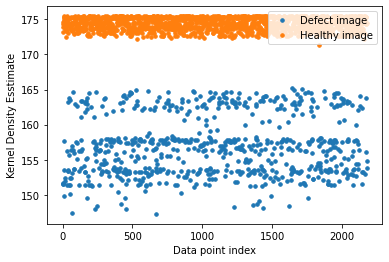

In [48]:
#Visualizing the kde anomaly scores with scatter plot
groups = df_scatter_kde.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.kde, marker='o', ms=3.5, linestyle='',
            label= "Healthy image" if name == 1 else "Defect image")
ax.legend(loc='upper right')
plt.ylabel("Kernel Density Esstimate")
plt.xlabel("Data point index")
plt.savefig(f'kde_scatter{camera}.png')
plt.show();

#3 Classification of anomalies

##3.1 Anomaly score==MSE

In [40]:
train_recon_errors=np.array(train_recon_errors)
test_recon_errors_class=df_mse.reconstructions.to_numpy()
y_actual=df_mse.label.to_numpy()

3.1.1 Classifier Object

In [41]:
#Classifier class:
class Classifier:
  def classify(self,test_recon_error,threshold):
    if test_recon_error < threshold:
      pred_label = 1
    else:
       pred_label = 0
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)


3.1.2 ROC Curve AUC Calculation

In [ ]:
classifier = Classifier()
tpr=[]
fpr=[]
thresholds=[]


for threshold in np.linspace(train_recon_errors.min(),train_recon_errors.max(),num=30):
  y_pred=[]
  for error in test_recon_errors_class:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)
  TP,FP,TN,FN = classifier.metrics(y_actual,y_pred)
  tpr.append(TP/(TP+FN))
  fpr.append(FP/(FP+TN))
  thresholds.append(threshold)

In [ ]:
# ROC Plot
plt.plot(fpr,tpr)
plt.xlabel("False Postivie rate")
plt.ylabel("True Positive rate")
plt.show()

In [ ]:
#AUC calculation
y_pred=[]
threshold = train_recon_errors.max()

for error in test_recon_errors:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)


auc_max = roc_auc_score(np.array(y_actual),np.array(y_pred))
print ("auc = " , auc_max)

3.1.3 Accuracy Calculation

In [ ]:
y_pred=[]
for error in test_recon_errors_class:
    pred_label= classifier.classify(error,train_recon_errors.max())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
print(accuracy_max)

##3.2 Anomaly score==SSIM

In [ ]:
train_ssim=np.array(train_ssim)
test_ssim_class=df_ssim.reconstructions.to_numpy()
y_actual_ssim=df_ssim.label.to_numpy()

3.2.1 Classifier Object

In [ ]:
class Classifier:
  def classify(self,test_recon_error,threshold):
    if test_recon_error < threshold:
      pred_label = 0
    else:
       pred_label = 1
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)


3.2.2 ROC Curve AUC Calculation

In [ ]:
classifier = Classifier()
tpr=[]
fpr=[]
thresholds=[]


for threshold in np.linspace(train_ssim.min(),train_ssim.max(),num=30):
  y_pred=[]
  for error in test_recon_errors_class:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)
  TP,FP,TN,FN = classifier.metrics(y_actual_ssim,y_pred)
  tpr.append(TP/(TP+FN))
  fpr.append(FP/(FP+TN))
  thresholds.append(threshold)

In [ ]:
plt.plot(fpr,tpr)
plt.xlabel("False Postivie rate")
plt.ylabel("True Positive rate")
plt.show()

In [ ]:
y_pred=[]
threshold = train_ssim.min()

for error in test_ssim_class:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)


auc_max = roc_auc_score(y_actual_ssim,y_pred)
print ("auc = " , auc_max)

3.2.3 Accuracy Calculation

In [ ]:
y_pred=[]
for error in test_ssim_class:
    pred_label= classifier.classify(error,train_ssim.min())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual_ssim,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
print(accuracy_max)

##3.3 Anomaly score==KDE

In [ ]:
test_kde_class=df_kde.kde.to_numpy()
y_actual_kde=df_kde.label.to_numpy()
train_kde=np.array(train_kde)

3.3.1 Classifier Object

In [ ]:
class Classifier:
  def classify(self,test_recon_error,threshold):
    if test_recon_error < threshold:
      pred_label = 0
    else:
       pred_label = 1
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)


3.3.2 ROC Curve AUC Calculation

In [ ]:
classifier = Classifier()
tpr=[]
fpr=[]
thresholds=[]


for threshold in np.linspace(train_kde.min(),train_kde.max(),num=30):
  y_pred=[]
  for error in test_kde_class:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)
  TP,FP,TN,FN = classifier.metrics(y_actual_kde,y_pred)
  tpr.append(TP/(TP+FN))
  fpr.append(FP/(FP+TN))
  thresholds.append(threshold)

In [ ]:
plt.plot(fpr,tpr)
plt.xlabel("False Postivie rate")
plt.ylabel("True Positive rate")
plt.show()

In [ ]:
y_pred=[]
threshold = train_kde.min()

for error in test_kde_class:
    pred_label= classifier.classify(error,threshold)
    y_pred.append(pred_label)


auc_max = roc_auc_score(y_actual_kde,y_pred)
print ("auc = " , auc_max)

3.3.3 Accuracy Calculation

In [ ]:
y_pred=[]
for error in test_kde_class:
    pred_label= classifier.classify(error,train_kde.min())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual_kde,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
print(accuracy_max)

##3.4 Anomaly Score==MSE+

In [ ]:
def create_dataset_plus_mse(normal_reconstructions,anomally_reconstructions,normal_kde,anomaly_kde):
  dataset=np.row_stack((np.column_stack((normal_reconstructions,normal_kde,np.ones((normal_reconstructions.shape[0],),dtype=np.int64))),np.column_stack((anomally_reconstructions,anomaly_kde,np.zeros((anomally_reconstructions.shape[0],),dtype=np.int64)))))
  df=pd.DataFrame(dataset,columns=['reconstructions','kde','label'])
  df = df.sample(frac=1).reset_index(drop=True)
  X=df.drop("label",axis=1)
  y=df["label"]
  return df

In [ ]:
df_mse_plus=create_dataset_plus_mse(np.array(normal_recon_errors_class),np.array(anomaly_recon_errors_class),np.array(normal_kde_class),np.array(anomaly_kde_class))

In [ ]:
df_mse_plus.head()

In [ ]:
train_kde_=np.array(train_kde)
train_recon_errors_=np.array(train_recon_errors)

test_kde_=df_mse_plus.kde.to_numpy()
test_recon_errors_=df_mse_plus.reconstructions.to_numpy()

y_actual_=df_mse_plus.label.to_numpy()



3.4.1 Classifier Object

In [ ]:
class Classifier:
  def classify(self,test_recon_error,test_kde,threshold_rcn,threshold_kde):
    if test_recon_error < threshold_rcn and test_kde > threshold_kde:
      pred_label = 1
    else:
       pred_label = 0
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)

3.4.2 Accuracy Calculation

In [ ]:
classifier = Classifier()
y_pred=[]
for i in range(test_kde_.shape[0]):
    pred_label= classifier.classify(test_recon_errors_[i],test_kde_[i],train_recon_errors_.max(),train_kde_.min())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual_,y_pred)

TP,FP,TN,FN = classifier.metrics(y_actual_,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
accuracy_max

##3.5 Anomaly Score==SSIM+

In [ ]:
def create_dataset_plus_ssim(normal_reconstructions,anomally_reconstructions,normal_kde,anomaly_kde):
  dataset=np.row_stack((np.column_stack((normal_reconstructions,normal_kde,np.ones((normal_reconstructions.shape[0],),dtype=np.int64))),np.column_stack((anomally_reconstructions,anomaly_kde,np.zeros((anomally_reconstructions.shape[0],),dtype=np.int64)))))
  df=pd.DataFrame(dataset,columns=['ssim','kde','label'])
  df = df.sample(frac=1).reset_index(drop=True)
  X=df.drop("label",axis=1)
  y=df["label"]
  return df

In [ ]:
df_ssim_plus=create_dataset_plus_ssim(np.array(normal_ssim_class),np.array(anomaly_ssim_class),np.array(normal_kde_class),np.array(anomaly_kde_class))

In [ ]:
df_ssim_plus.head()

In [ ]:
train_ssim_=np.array(train_ssim)
train_kde_=np.array(train_kde)
test_ssim_=df_ssim_plus.ssim.to_numpy()
test_kde_=df_ssim_plus.kde.to_numpy()
y_actual_=df_ssim_plus.label.to_numpy()


3.5.1 Classifier Object

In [ ]:
class Classifier:
  def classify(self,test_ssim,test_kde,threshold_ssim,threshold_kde):
    if test_ssim < threshold_ssim and test_kde < threshold_kde:
      pred_label = 0
    else:
       pred_label = 1
    return (pred_label)
  def metrics(self,y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
      if y_actual[i] == y_pred[i] == 1:
        TP += 1
      elif y_pred[i] == 1 and y_actual[i] != y_pred[i]:
        FP += 1
      elif y_actual[i] == y_pred[i] == 0:
        TN +=1
      elif y_pred[i] == 0 and y_actual[i] != y_pred[i]:
        FN+=1

    return (TP, FP,TN,FN)

3.5.2 Accuracy Calculation

In [ ]:
classifier = Classifier()
y_pred=[]
for i in range(test_kde_.shape[0]):
    pred_label= classifier.classify(test_ssim_[i],test_kde_[i],train_ssim_.min(),train_kde_.min())
    y_pred.append(pred_label)
TP,FP,TN,FN = classifier.metrics(y_actual_,y_pred)

TP,FP,TN,FN = classifier.metrics(y_actual_,y_pred)
accuracy_max=(TP+TN)/(TP+FP+TN+FN)
recall_max=TP/(TP+FN)
precision_max=TP/(TP+FP)
accuracy_max

#4 Localization

## 4.1 Localization with MSE

1/1 [==============================] - 0s 51ms/step


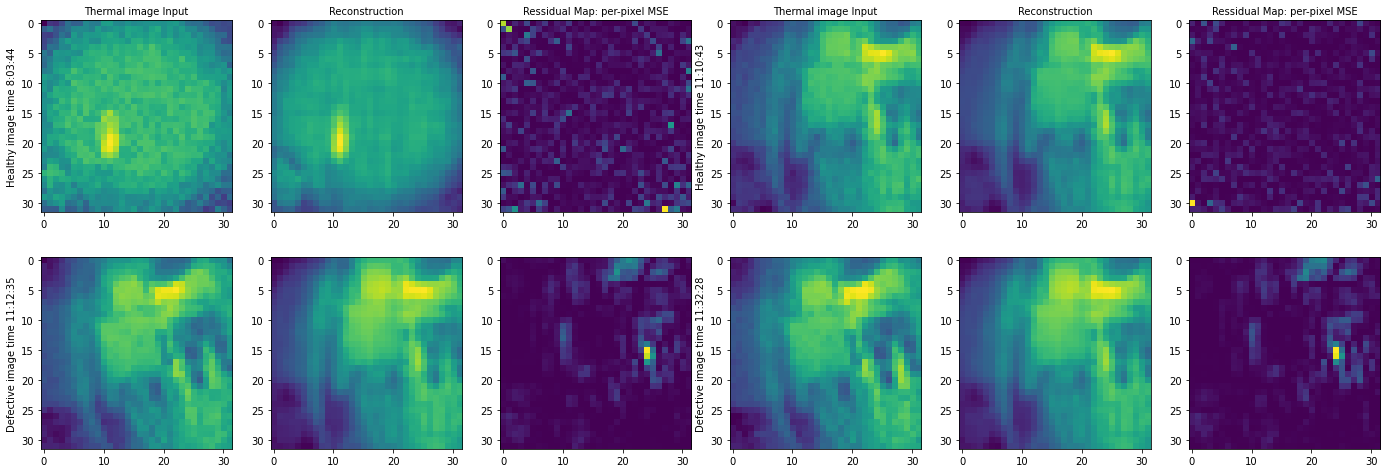

In [49]:

import matplotlib.pyplot as plt
rows, cols = 2, 6
fig, ax = plt.subplots(rows, cols,figsize=(24,8))

predicted = cae_mse.predict(healthy_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[0,0].imshow(healthy_start)
ax[0,0].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[0,0].set_ylabel("Healthy image time 8:03:44",fontsize=10, fontweight=20)
ax[0,1].imshow(predicted)
ax[0,1].set_title(f"Reconstruction",fontsize=10, fontweight=20)
residual=(healthy_start-predicted)**2
ax[0,2].imshow(residual)
ax[0,2].set_title(f"Ressidual Map: per-pixel MSE",fontsize=10, fontweight=20)

predicted = cae_mse.predict(healthy_mid.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[0,3].imshow(healthy_mid)
ax[0,3].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[0,3].set_ylabel("Healthy image time 11:10:43",fontsize=10, fontweight=20)
ax[0,4].imshow(predicted)
ax[0,4].set_title(f"Reconstruction",fontsize=10, fontweight=20)

residual=(healthy_mid-predicted)**2
ax[0,5].imshow(residual)
ax[0,5].set_title(f"Ressidual Map: per-pixel MSE",fontsize=10, fontweight=20)



predicted = cae_mse.predict(faulty_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[1,0].imshow(faulty_start)
ax[1,0].set_ylabel("Defective image time 11:12:35",fontsize=10, fontweight=20)

ax[1,1].imshow(predicted)
residual=(faulty_start-predicted)**2
ax[1,2].imshow(residual)



predicted = cae_mse.predict(faulty_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[1,3].imshow(faulty_end)
ax[1,3].set_ylabel("Defective image time 11:32:28",fontsize=10, fontweight=20)
ax[1,4].imshow(predicted)
residual=(faulty_end-predicted)**2
ax[1,5].imshow(residual)

plt.show()

##4.2 Localization with SSIM

In [50]:
#function finding indeces of smalest K
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    indexlist=np.array(np.unravel_index(idx, arr.shape))[:, range(k)].tolist()
    return tuple(indexlist)
  

In [51]:
k1=5
patch_size_1=3
k2=30
patch_size_2=5

1/1 [==============================] - 0s 19ms/step


<ipython-input-52-3f7f44c9d32e>:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:38: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:56: User

1/1 [==============================] - 0s 23ms/step


<ipython-input-52-3f7f44c9d32e>:140: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:148: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:156: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
<ipython-input-52-3f7f44c9d32e>:164: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)


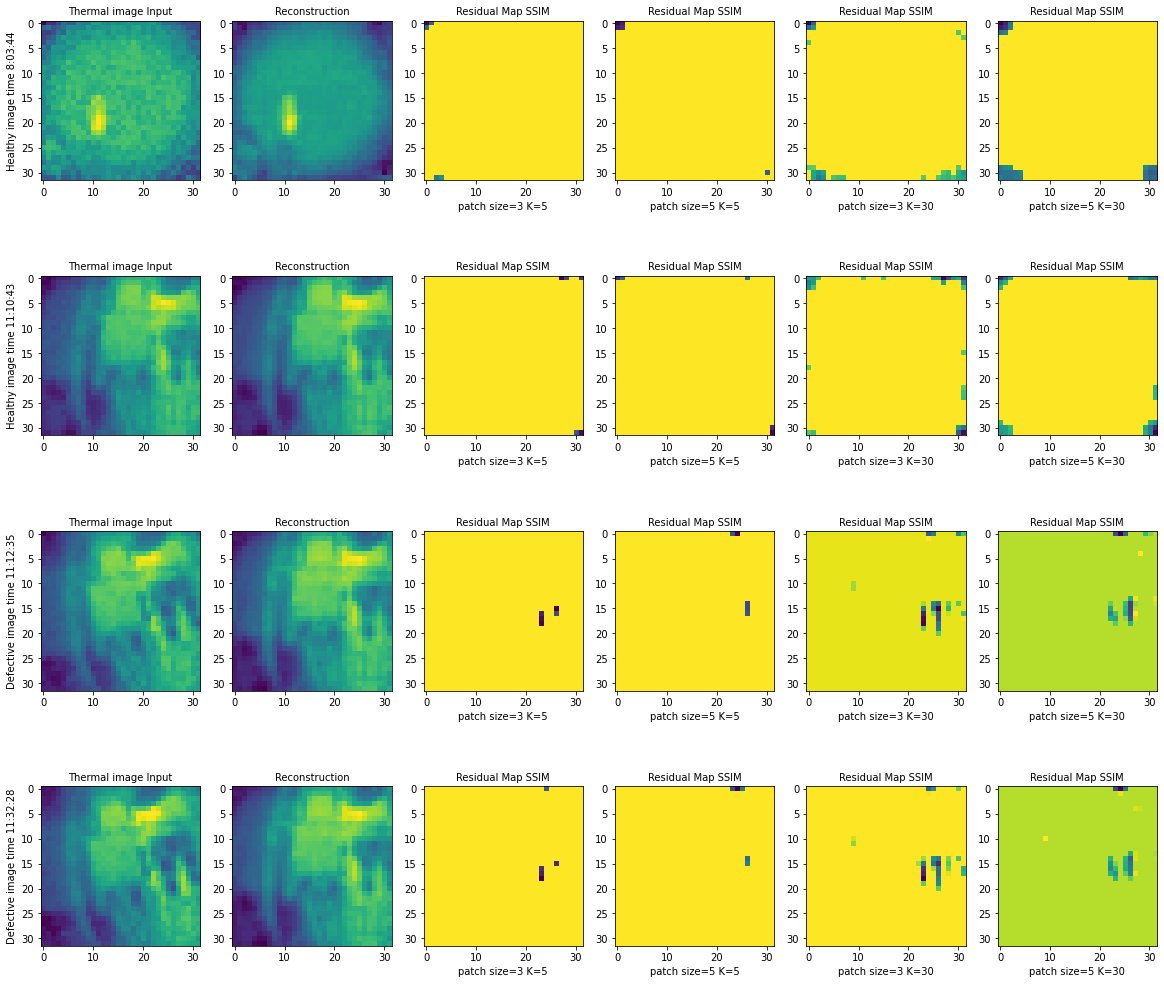

In [52]:
rows, cols = 4, 6
fig, ax = plt.subplots(rows, cols,figsize=(20,18))

#Row 1
predicted = cae_ssim.predict(healthy_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[0,0].imshow(healthy_start)
ax[0,0].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[0,0].set_ylabel(f"Healthy image time 8:03:44",fontsize=10, fontweight=20)

ax[0,1].imshow(predicted)
ax[0,1].set_title(f"Reconstruction",fontsize=10, fontweight=20)

ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[0,2].imshow(mask_array)
ax[0,2].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[0,2].set_xlabel(f"patch size={patch_size_1} K={k1}")

ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[0,3].imshow(mask_array)
ax[0,3].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[0,3].set_xlabel(f"patch size={patch_size_2} K={k1}")

ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[0,4].imshow(mask_array)
ax[0,4].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[0,4].set_xlabel(f"patch size={patch_size_1} K={k2}")

ssim_val,residual,full_=ssim(healthy_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[0,5].imshow(mask_array)
ax[0,5].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[0,5].set_xlabel(f"patch size={patch_size_2} K={k2}")

#Row 2
predicted = cae_ssim.predict(healthy_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[1,0].imshow(healthy_end)
ax[1,0].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[1,0].set_ylabel(f"Healthy image time 11:10:43",fontsize=10, fontweight=20)

ax[1,1].imshow(predicted)
ax[1,1].set_title(f"Reconstruction",fontsize=10, fontweight=20)

ssim_val,residual,full_=ssim(healthy_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[1,2].imshow(mask_array)
ax[1,2].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[1,2].set_xlabel(f"patch size={patch_size_1} K={k1}")

ssim_val,residual,full_=ssim(healthy_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[1,3].imshow(mask_array)
ax[1,3].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[1,3].set_xlabel(f"patch size={patch_size_2} K={k1}")

ssim_val,residual,full_=ssim(healthy_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[1,4].imshow(mask_array)
ax[1,4].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[1,4].set_xlabel(f"patch size={patch_size_1} K={k2}")

ssim_val,residual,full_=ssim(healthy_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.ones((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[1,5].imshow(mask_array)
ax[1,5].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[1,5].set_xlabel(f"patch size={patch_size_2} K={k2}")

#Row 3
predicted = cae_ssim.predict(faulty_start.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[2,0].imshow(faulty_start)
ax[2,0].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[2,0].set_ylabel(f"Defective image time 11:12:35",fontsize=10, fontweight=20)

ax[2,1].imshow(predicted)
ax[2,1].set_title(f"Reconstruction",fontsize=10, fontweight=20)

ssim_val,residual,full_=ssim(faulty_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[2,2].imshow(mask_array)
ax[2,2].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[2,2].set_xlabel(f"patch size={patch_size_1} K={k1}")

ssim_val,residual,full_=ssim(faulty_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[2,3].imshow(mask_array)
ax[2,3].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[2,3].set_xlabel(f"patch size={patch_size_2} K={k1}")

ssim_val,residual,full_=ssim(faulty_start,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[2,4].imshow(mask_array)
ax[2,4].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[2,4].set_xlabel(f"patch size={patch_size_1} K={k2}")

ssim_val,residual,full_=ssim(faulty_start,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[2,5].imshow(mask_array)
ax[2,5].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[2,5].set_xlabel(f"patch size={patch_size_2} K={k2}")

#Row 4
predicted = cae_ssim.predict(faulty_end.reshape(1,32,32,1)) 
predicted=np.reshape(predicted,(32,32))
ax[3,0].imshow(faulty_end)
ax[3,0].set_title(f"Thermal image Input",fontsize=10, fontweight=20)
ax[3,0].set_ylabel(f"Defective image time 11:32:28",fontsize=10, fontweight=20)

ax[3,1].imshow(predicted)
ax[3,1].set_title(f"Reconstruction",fontsize=10, fontweight=20)

ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[3,2].imshow(mask_array)
ax[3,2].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[3,2].set_xlabel(f"patch size={patch_size_1} K={k1}")

ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k1)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[3,3].imshow(mask_array)
ax[3,3].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[3,3].set_xlabel(f"patch size={patch_size_2} K={k1}")

ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_1,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[3,4].imshow(mask_array)
ax[3,4].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[3,4].set_xlabel(f"patch size={patch_size_1} K={k2}")

ssim_val,residual,full_=ssim(faulty_end,predicted,gradient=True,win_size=patch_size_2,multichannel=False,full=True)
indices = get_indices_of_k_smallest((full_),k2)
mask_array = np.zeros((32,32), dtype=float)
mask_array[indices]=full_[indices]
ax[3,5].imshow(mask_array)
ax[3,5].set_title(f"Residual Map SSIM",fontsize=10, fontweight=20)
ax[3,5].set_xlabel(f"patch size={patch_size_2} K={k2}")

plt.show()